In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize
from pathlib import Path

In [2]:
# Images directory

figsdir = Path.cwd() / 'ex8figs'
figsdir.mkdir(parents=True, exist_ok=True);

In [4]:
# Data directory

datadir = Path.cwd() / 'data/ex8'

# Anomaly detection

## Low dimensional set

In [5]:
data = loadmat(datadir / 'ex8data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [6]:
x = data['X']
print('x: {}'.format(x.shape))

x: (307, 2)


In [7]:
def plot_data(x):
    plt.scatter(x[:, 0], x[:, 1], marker='x', s=10)
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (MB/s)')

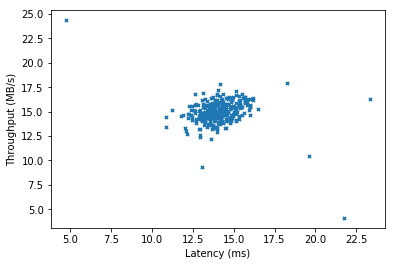

In [8]:
plot_data(x)

plt.savefig(figsdir / 'data.png', bbox_inches='tight')

In [9]:
def estimate_gaussian_params(x):
    mu = np.mean(x, axis=0)
    sigma2 = np.square(np.std(x, axis=0))
    
    return mu, sigma2

In [10]:
def multivariate_gaussian(x, mu, sigma2):
    k = len(mu)
    
    if sigma2.ndim == 1:
        sigma2 = np.diag(sigma2)
        
    x = x - mu.ravel()
    
    return np.power(2 * np.pi, - k / 2) * np.power(np.linalg.det(sigma2), -0.5) * np.exp(-0.5 * np.sum(np.dot(x, np.linalg.pinv(sigma2)) * x, axis=1))

In [11]:
mu, sigma2 = estimate_gaussian_params(x)

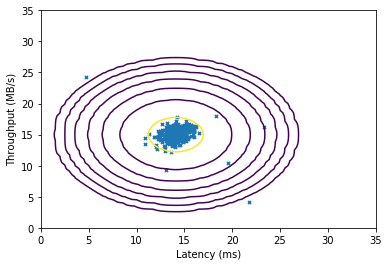

In [12]:
xx, yy = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
z = multivariate_gaussian(np.c_[xx.ravel(), yy.ravel()], mu, sigma2)
z = z.reshape(xx.shape)

plot_data(x)
if np.sum(np.isinf(z)) == 0:
    plt.contour(xx, yy, z, np.power(10., np.arange(-20, 0, 3)))

plt.savefig(figsdir / 'contours_distribution_fit.png', bbox_inches='tight')

In [13]:
def select_threshold(y_val, p_val):
    best_epsilon = 0
    best_F1 = 0
    min_p_val = np.min(p_val)
    max_p_val = np.max(p_val)
    
    for epsilon in np.linspace(min_p_val, max_p_val, 1000):
        pred = p_val < epsilon
        
        tp = np.sum((pred == 1) * (y_val == 1))
        fp = np.sum((pred == 1) * (y_val == 0))
        fn = np.sum((pred == 0) * (y_val == 1))
        
        if tp + fp == 0 or tp + fn == 0:
            continue
            
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        F1 = (2 * prec * rec) / (prec + rec)
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
            
    return best_epsilon, best_F1

In [14]:
x_val = data['Xval']
y_val = data['yval'].ravel()
print('x_val: {}\ny_val: {}'.format(x_val.shape, y_val.shape))

x_val: (307, 2)
y_val: (307,)


In [15]:
p = multivariate_gaussian(x, mu, sigma2)
p_val = multivariate_gaussian(x_val, mu, sigma2)
epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using cross-validation: {}'.format(epsilon))
print('Best F1 score on cross-validation set: {}'.format(F1))

Best epsilon found using cross-validation: 8.999852631901394e-05
Best F1 score on cross-validation set: 0.8750000000000001


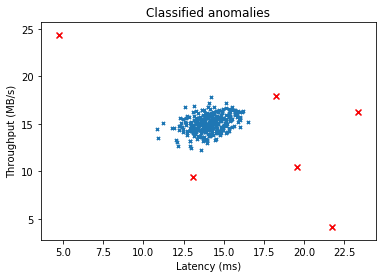

In [16]:
outliers = np.argwhere(p < epsilon)

plot_data(x)
plt.scatter(x[outliers, 0], x[outliers, 1], marker='x', c='r')
plt.title('Classified anomalies')

plt.savefig(figsdir / 'anomalies.png', bbox_inches='tight')

## High dimensional set

In [17]:
data = loadmat(datadir / 'ex8data2.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [18]:
x = data['X']
x_val = data['Xval']
y_val = data['yval'].ravel()

print('x: {}\nx_val: {}\ny_val: {}'.format(x.shape, x_val.shape, y_val.shape))

x: (1000, 11)
x_val: (100, 11)
y_val: (100,)


In [19]:
mu, sigma2 = estimate_gaussian_params(x)
p = multivariate_gaussian(x, mu, sigma2)
p_val = multivariate_gaussian(x_val, mu, sigma2)
epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using cross-validation set: {}'.format(epsilon))
print('# outliers found: {}'.format(np.sum(p < epsilon)))

Best epsilon found using cross-validation set: 1.378607498200024e-18
# outliers found: 117


# Recommender systems

In [20]:
data = loadmat(datadir / 'ex8_movies.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [21]:
y = data['Y']
r = data['R']

print('y: {}\nr: {}'.format(y.shape, r.shape))

y: (1682, 943)
r: (1682, 943)


In [22]:
print('Average rating for movie 1 (Toy Story): {}'.format(np.mean(y[0, r[0] == 1])))

Average rating for movie 1 (Toy Story): 3.8783185840707963


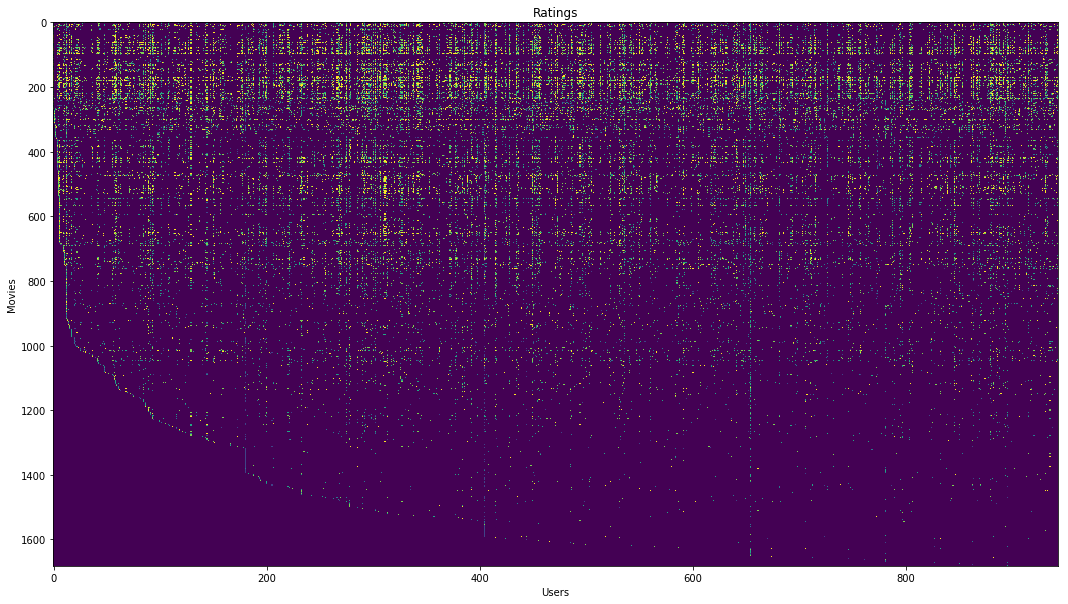

In [23]:
plt.figure().set_size_inches(18, 10)
plt.imshow(y, aspect='auto')
plt.title('Ratings')
plt.xlabel('Users')
plt.ylabel('Movies')

plt.savefig(figsdir / 'ratings.png', bbox_inches='tight')

In [24]:
params = loadmat(datadir / 'ex8_movieParams.mat')
params.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [27]:
num_users = 4
num_movies = 5
num_features = 3

x = params['X'][:num_movies, :num_features]
theta = params['Theta'][:num_users, :num_features]
y = y[:num_movies, :num_users]
r = r[:num_movies, :num_users]

print('x: {}\ntheta: {}\ny: {}\nr: {}'.format(x.shape, theta.shape, y.shape, r.shape))

x: (5, 3)
theta: (4, 3)
y: (5, 4)
r: (5, 4)


In [28]:
def cost_function(params, y, r, num_users, num_movies, num_features, reg):
    x = params[:num_movies*num_features].reshape(num_movies, num_features)
    theta = params[num_movies*num_features:].reshape(num_users, num_features)
    
    J = np.sum(np.square(x.dot(theta.T) * r - y)) / 2 + reg / 2 * np.sum(np.square(theta)) + reg / 2 * np.sum(np.square(x))
    x_grad = (x.dot(theta.T) * r - y).dot(theta) + reg * x
    theta_grad = (x.dot(theta.T) * r - y).T.dot(x) + reg * theta
    
    return J, np.r_[x_grad.ravel(), theta_grad.ravel()]

In [29]:
params = np.r_[x.ravel(), theta.ravel()]
J, grad = cost_function(params, y, r, num_users, num_movies, num_features, reg=0)
print('Cost without regularization: {}'.format(J))
print('Gradient without regularization:\n{}'.format(grad))

Cost without regularization: 22.224603725685675
Gradient without regularization:
[ -2.52899165   7.57570308  -1.89979026  -0.56819597   3.35265031
  -0.52339845  -0.83240713   4.91163297  -0.76677878  -0.38358278
   2.26333698  -0.35334048  -0.80378006   4.74271842  -0.74040871
 -10.5680202    4.62776019  -7.16004443  -3.05099006   1.16441367
  -3.47410789   0.           0.           0.           0.
   0.           0.        ]


In [30]:
params = np.r_[x.ravel(), theta.ravel()]
J, grad = cost_function(params, y, r, num_users, num_movies, num_features, reg=1.5)
print('Cost with regularization (lambda = 1.5): {}'.format(J))
print('Gradient with regularization (lambda = 1.5):\n{}'.format(grad))

Cost with regularization (lambda = 1.5): 31.34405624427422
Gradient with regularization (lambda = 1.5):
[ -0.95596339   6.97535514  -0.10861109   0.60308088   2.77421145
   0.25839822   0.12985616   4.0898522   -0.89247334   0.29684395
   1.06300933   0.66738144   0.60252677   4.90185327  -0.19747928
 -10.13985478   2.10136256  -6.76563628  -2.29347024   0.48244098
  -2.99791422  -0.64787484  -0.71820673   1.27006666   1.09289758
  -0.40784086   0.49026541]


In [31]:
movie_list = list()
with open(datadir / 'movie_ids.txt') as movies:
    for line in movies:
        _, movie_name = line.split(' ', 1)
        movie_list.append(movie_name.strip())
        
movie_list[:10]

['Toy Story (1995)',
 'GoldenEye (1995)',
 'Four Rooms (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)',
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 'Twelve Monkeys (1995)',
 'Babe (1995)',
 'Dead Man Walking (1995)',
 'Richard III (1995)']

In [32]:
my_ratings = np.zeros(len(movie_list), dtype='int')

my_ratings[0] = 4
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65]= 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354]= 5

for i in range(len(movie_list)):
    if my_ratings[i] > 0:
        print('Rated {} for movie {}: {}'.format(my_ratings[i], i, movie_list[i]))

Rated 4 for movie 0: Toy Story (1995)
Rated 3 for movie 6: Twelve Monkeys (1995)
Rated 5 for movie 11: Usual Suspects, The (1995)
Rated 4 for movie 53: Outbreak (1995)
Rated 5 for movie 63: Shawshank Redemption, The (1994)
Rated 3 for movie 65: While You Were Sleeping (1995)
Rated 5 for movie 68: Forrest Gump (1994)
Rated 2 for movie 97: Silence of the Lambs, The (1991)
Rated 4 for movie 182: Alien (1979)
Rated 5 for movie 225: Die Hard 2 (1990)
Rated 5 for movie 354: Sphere (1998)


In [33]:
data = loadmat(datadir / 'ex8_movies.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [34]:
y = np.c_[my_ratings, data['Y']]
r = np.c_[(my_ratings != 0), data['R']]

print('y: {}\nr: {}'.format(y.shape, r.shape))

y: (1682, 944)
r: (1682, 944)


In [35]:
def normalize_ratings(y, r):
    y_mean = np.zeros(len(y))
    y_norm = np.zeros(y.shape)
    
    for i in range(len(y)):
        idx = r[i] == 1
        y_mean[i] = np.mean(y[i, idx])
        y_norm[i, idx] = y[i, idx] - y_mean[i]
        
    return y_mean, y_norm

In [36]:
# Normalize ratings

y_mean, y_norm = normalize_ratings(y, r)

np.mean(y_norm, axis=1)

array([-2.54034082e-17, -1.88173394e-18,  1.12904036e-17, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [37]:
num_users = y.shape[1]
num_movies = y.shape[0]
num_features = 10

# Set initial parameters

x = np.random.randn(num_movies, num_features)
theta = np.random.randn(num_users, num_features)

init_params = np.r_[x.ravel(), theta.ravel()]
reg = 10

# Learning

res = minimize(cost_function, init_params, args=(y_norm, r, num_users, num_movies, num_features, reg),
               jac=True, method='CG', options={'maxiter': 100})

x = res.x[:num_movies*num_features].reshape(num_movies, num_features)
theta = res.x[num_movies*num_features:].reshape(num_users, num_features)

In [38]:
# Recommendations for me

pred = x.dot(theta.T)
my_pred = pred[:, 0] + y_mean

idx = np.argsort(my_pred)[::-1]

for i in range(10):
    j = idx[i]
    print('Predicting rating {:.1f} for movie {}'.format(my_pred[j], movie_list[j]))

Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.0 for movie Prefontaine (1997)
